# Эксперимент E: Путешествие во времени и Обратимость

## Time Travel & Reversibility in RSL World

**Версия**: 1.1.0  
**Дата**: 2025-12-20  
**Автор**: RSL Research Team

---

## 1. Введение

Эксперимент E исследует **обратимость динамики** RSL-мира и возможность "путешествия во времени". 

В детерминированной системе с обратимыми правилами математически существует возможность "отката" состояния. Однако ключевой вопрос: **является ли это "настоящим" путешествием во времени?**

### 1.1 Два варианта "путешествия во времени"

| Вариант | Описание | Результат для наблюдателя |
|---------|----------|---------------------------|
| **A. Глобальный откат** | $S_{t+T} \to S_t$ (весь мир + наблюдатель) | Наблюдатель **не замечает** отката |
| **B. Observer-only reset** | $O_{t+T} \to O_t$ при фикс. $X_{t+T}$ | **Амнезия**, не путешествие |

### 1.2 Центральный вопрос

> **Можно ли передать информацию из будущего в прошлое?**

Ответ: **НЕТ**, при условиях:
- Мир замкнут (нет внешнего носителя информации)
- Reset не оставляет маркеров в $X$
- Нет частично неоткатываемых степеней свободы

---

## 2. Математическая модель

### 2.1 Структура состояния

Полное состояние системы:

$$S(t) = (X(t), O(t))$$

где:
- $X(t)$ — **микрофизика** (World): спины, φ-поле, граф
- $O(t)$ — **наблюдатель**: память, семантика, история

**Компоненты микрофизики:**
$$X(t) = \{s[0..N-1], \phi[0..N-1], \mathcal{G}, t\}$$

- $s_i \in \{-1, +1\}$ — спины (дискретные)
- $\phi_i \in \mathbb{R}$ — гравитационный потенциал
- $\mathcal{G} = (V, E)$ — граф связности
- $t \in \mathbb{Z}_{\geq 0}$ — дискретное время

**Компоненты наблюдателя:**
$$O(t) = \{\text{IFACEHistory}, \text{SemanticState}, \text{cache}\}$$

### 2.2 Оператор эволюции

Эволюция мира определяется оператором $F$:

$$S(t+1) = F(S(t))$$

Для **обратимой** системы существует $F^{-1}$:

$$S(t) = F^{-1}(S(t+1))$$

### 2.3 SM-правила (обратимые)

Стандартная Модель использует **взаимно-обратные** правила:

$$R_{\rightarrow}: \quad (++-) \to (-++)$$
$$R_{\leftarrow}: \quad (-++) \to (++-)$$

Это гарантирует **микроскопическую обратимость**: каждое применение правила может быть отменено.

### 2.4 Динамика φ-поля и её обратимость

#### Прямая эволюция:
$$\phi^{(t+1)} = \phi^{(t)} + D_\phi \cdot \Delta_{\mathcal{G}} \phi^{(t)} + \beta \cdot \rho_s^{(t)} - \gamma \cdot \phi^{(t)}$$

где:
- $\Delta_{\mathcal{G}}$ — лапласиан графа
- $\rho_s = s - \langle s \rangle$ — отклонение от среднего (источник)
- $D_\phi, \beta, \gamma$ — коэффициенты диффузии, источника, затухания

#### Проблема обратимости φ:

В общем случае уравнение диффузии **не обратимо** (сжимающее отображение). 

**Решение в данном эксперименте:** φ-поле откатывается через **хранение $\phi^{(t)}$ в StepRecord**.

$$\phi_{\text{rollback}} = \texttt{StepRecord}[t].\phi\_\text{before}$$

Это гарантирует точную обратимость за счёт хранения полного состояния.

#### Альтернативный подход (статическое φ):

Если φ вычисляется как решение уравнения Пуассона:
$$L_{\mathcal{G}} \phi = \rho_s$$

то обратимость φ **автоматически следует** из обратимости $s$.

---

## 3. Хеш-функции для верификации

### 3.1 micro_hash (только физика X)

$$\texttt{micro\_hash}(X) = \text{SHA256}(t \| N \| s \| \text{quant}(\phi) \| \text{canon}(E))$$

**Компоненты:**
- $t$ — время (int64)
- $N$ — размер (int32)
- $s$ — спины (int8 array)
- $\text{quant}(\phi)$ — квантизованное φ-поле
- $\text{canon}(E)$ — канонические рёбра

**Важно:** `micro_hash` **НЕ включает**:
- `omega_cycles` (детекторы Ω-циклов)
- `IFACEState`, `IFACEHistory`
- `SemanticState`
- Любые кэши наблюдателя

**Квантизация φ-поля:**
$$\text{quant}(\phi)_i = \text{round}\left(\frac{\phi_i - \langle\phi\rangle}{\varepsilon}\right), \quad \varepsilon = 10^{-12}$$

**Канонизация рёбер:**
$$\text{canon}(E) = \text{sort}\left(\{(\min(u,v), \max(u,v)) : (u,v) \in E\}\right)$$

### 3.2 full_hash (физика + наблюдатель)

$$\texttt{full\_hash}(S) = \text{SHA256}(\texttt{micro\_hash}(X) \| \text{hash}(O))$$

### 3.3 Контракт пересчёта (recompute_contract)

Для внешней верификации фиксируется:
- Точный порядок байт в хеше
- Порядок полей: `t → N → s → phi_quant → edges`
- Endianness: little-endian
- Квантизация: mean-subtraction + round(φ/ε)

---

## 4. Гипотезы эксперимента

| ID | Гипотеза | Формальный критерий |
|----|----------|---------------------|
| **H1** | SM-правила обратимы | $\forall s: R_\leftarrow(R_\rightarrow(s)) = s$ |
| **H2** | φ-поле обратимо при фикс. $s$ | $\|\phi_0 - \phi_{\text{rollback}}\|_\infty < 10^{-10}$ |
| **H3** | micro_hash сохраняется после rollback | $h(S_0) = h(F^{-T}(F^T(S_0)))$ |
| **H4** | Observer reset не меняет физику | $\texttt{micro\_hash}(X)$ инвариант при $\texttt{reset}(O)$ |
| **H5** | Нет передачи информации в прошлое | $I(Y;Z) \approx 0$ для всех протоколов |

---

## 5. Тесты

### 5.1 Тест R0: Микро-обратимость

**Процедура:**
1. Сохранить $S_0$, вычислить $h_0 = \texttt{micro\_hash}(S_0)$
2. Выполнить $T$ шагов вперёд: $S_T = F^T(S_0)$
3. Выполнить $T$ шагов назад: $S'_0 = F^{-T}(S_T)$
4. Вычислить $h'_0 = \texttt{micro\_hash}(S'_0)$

**Критерий:** $h_0 = h'_0$

### 5.2 Тест T5: Детерминизм

**Процедура:**
1. Запустить эволюцию с seed $k$ → получить $h_1$
2. Запустить эволюцию с seed $k$ → получить $h_2$

**Критерий:** $h_1 = h_2$

### 5.3 Тест T6: Целостность StepRecord

**StepRecord** — журнал шага для отката:

```
StepRecord = {
    t: int,                    # время ДО шага
    s_before: np.ndarray,      # спины до
    phi_before: np.ndarray,    # φ до
    applied_positions: List[int],   # позиции применённых правил
    applied_rules: List[str],       # имена правил
    pre_hash: str,             # hash до
    post_hash: str             # hash после
}
```

**Критерий:** Цепочка хешей: $\texttt{record}[i].\texttt{post\_hash} = \texttt{record}[i+1].\texttt{pre\_hash}$

### 5.4 Тест T7: Стабильность Hash

**Критерий:** $\texttt{micro\_hash}(S)$ детерминирован — многократные вызовы дают одинаковый результат.

### 5.5 Тест OR: Observer Reset

**Процедура:**
1. Вычислить $h_X = \texttt{micro\_hash}(X)$
2. Выполнить $\texttt{reset}(O)$ (очистить память наблюдателя)
3. Вычислить $h'_X = \texttt{micro\_hash}(X)$

**Критерий:** $h_X = h'_X$ (физика не изменилась)

### 5.6 Тест NIP: No Information to Past

**Цель:** Доказать, что невозможно передать информацию из будущего в прошлое.

#### Формализация:

Определим:
- $Y = g(O_{t+T})$ — измерение в "будущем" (бит)
- $Z = h(O_t)$ — состояние памяти в "прошлом" после rollback/reset (бит)

**Взаимная информация:**
$$I(Y;Z) = \sum_{y,z} p(y,z) \log_2 \frac{p(y,z)}{p(y)p(z)}$$

#### Протоколы атак:

| Атака | Описание | Ожидание |
|-------|----------|----------|
| **A** | Rollback and read: $F^T \to \text{Rollback}_T \to \text{read } Z$ | $I(Y;Z) = 0$ |
| **B** | Reset and replay: $F^T \to \text{Reset} \to \text{read } Z$ | $I(Y;Z) = 0$ |
| **C** | Rollback + reset + replay | $I(Y;Z) = 0$ |

#### Критерий PASS:

Для каждого протокола:
- $I_{\text{obs}} \leq I_{\text{null},95\%} + \varepsilon$
- $\text{accuracy} \leq \text{base\_rate} + \delta$

С использованием permutation test (p-value > 0.05 после Bonferroni correction).

---

## 6. Философские следствия

### 6.1 Почему обратимость ≠ путешествие во времени

**Глобальный откат** ($S_T \to S_0$):
- Состояние мира восстановлено
- Память наблюдателя **тоже** восстановлена
- Наблюдатель "забыл" что был в будущем
- С его точки зрения — **ничего не произошло**

**Observer-only reset** ($O_T \to O_0$ при фикс. $X_T$):
- Мир остаётся в состоянии $X_T$
- Наблюдатель "забыл" историю
- Это **амнезия**, не путешествие во времени
- Законы физики мира изменились (с точки зрения наблюдателя)

### 6.2 Условия невозможности передачи информации в прошлое

1. **Мир замкнут** — нет внешнего буфера/канала
2. **Reset не оставляет маркеров** — нет скрытых степеней свободы в $X$
3. **Полный откат** — нет частично неоткатываемых переменных

При нарушении любого условия появляется лазейка для $I(Y;Z) > 0$.

### 6.3 Ключевой вывод

> **Reversibility ≠ Time Travel**
>
> Математическая обратимость динамики не даёт возможности "изменить прошлое".
> Внутренний наблюдатель либо не замечает отката, либо испытывает амнезию.

---

## 7. Параметры эксперимента

| Параметр | Значение | Описание |
|----------|----------|----------|
| $N$ | 512 | Количество узлов |
| $\alpha$ | 2.0 | Параметр графа |
| $L$ | 3 | Длина паттерна правил |
| $T_{\text{forward}}$ | 50 | Шагов вперёд |
| $T_{\text{backward}}$ | 50 | Шагов назад |
| $N_{\text{seeds}}$ | 10 | Количество тестовых seeds |
| $\varepsilon_{\phi}$ | $10^{-12}$ | Точность квантизации φ |
| $n_{\text{perm}}$ | 5000 | Permutation test iterations |

---

## 8. Артефакты для внешней верификации

| Файл | Описание |
|------|----------|
| `experiment_E_report.json` | Основной отчёт с результатами |
| `tables/r0_trials.parquet` | Детали теста R0 по seeds |
| `tables/nip_trials.parquet` | Результаты NIP по протоколам |
| `tables/nip_summary.parquet` | MI, accuracy, p-value по протоколам |
| `manifest.json` | SHA256 всех артефактов |

---

## 9. Структура ноутбука

1. **Импорты и параметры**
2. **Создание мира с SM-правилами**
3. **Инструменты обратимости** (StepRecord, hash функции)
4. **ReversibleEvolutionEngine**
5. **Тест T5** — Детерминизм
6. **Тест R0** — Микро-обратимость
7. **Тест T6** — Целостность StepRecord
8. **Тест T7** — Стабильность Hash
9. **Тест OR** — Observer Reset
10. **Тест NIP** — No Information to Past
11. **Визуализация**
12. **Финальный отчёт**

In [1]:
# =============================================================================
# ЭКСПЕРИМЕНТ E: ПУТЕШЕСТВИЕ ВО ВРЕМЕНИ И ОБРАТИМОСТЬ
# =============================================================================
#
# Цель: Проверить обратимость динамики RSL-мира
#
# Гипотезы:
#   H1: SM-правила (++- ↔ -++) обратимы
#   H2: φ-поле обратимо при фиксированных спинах
#   H3: Полный micro_hash сохраняется после rollback
#   H4: Observer reset не меняет физику мира
# =============================================================================

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timezone
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional, Set, Any
import subprocess
import hashlib
import json
from scipy.sparse.linalg import spsolve
from scipy import stats
from collections import deque
import copy

# Определяем project_root
project_root = str(Path(os.getcwd()).parent) if os.path.basename(os.getcwd()) == 'notebooks' else os.getcwd()
sys.path.insert(0, project_root)

VERSION = "1.0.0"

# Импорт симулятора World
from world.core.world import World, WorldConfig
from world.core.rules import RuleSet, Rule
from world.core.lattice import Lattice, LatticeState
from world.core.evolution import EvolutionEngine
from world.core.graph_structure import GraphStructure, GraphConfig

# Настройка matplotlib
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.unicode_minus'] = False

print("=" * 70)
print("ЭКСПЕРИМЕНТ E: ПУТЕШЕСТВИЕ ВО ВРЕМЕНИ И ОБРАТИМОСТЬ")
print("=" * 70)

# =============================================================================
# БАЗОВЫЕ ПАРАМЕТРЫ
# =============================================================================
RSL_N = 512
RSL_ALPHA = 2.0
RSL_L = 3
BASE_SEED = 42

# Параметры тестов обратимости
T_FORWARD = 50           # Шагов вперёд
T_BACKWARD = 50          # Шагов назад
N_SEEDS = 10             # Количество seeds для тестирования

# Параметры φ-поля
PHI_QUANT_EPS = 1e-12    # Квантизация для hash

# Пороги для гипотез
THRESHOLDS = {
    # H1: Обратимость спинов
    'h1_spin_match_rate': 1.0,     # Должно быть 100%
    # H2: Обратимость φ-поля
    'h2_phi_max_diff': 1e-10,      # max|φ_0 - φ_rollback|
    # H3: micro_hash match
    'h3_hash_match': True,         # Должен совпадать
    # H4: Observer reset
    'h4_world_unchanged': True,    # X не меняется
    # Тесты
    'test5_determinism': True,
    'test6_record_integrity': True,
    'test7_hash_stability': True,
}

# =============================================================================
# ВЕРСИОНИРОВАНИЕ И RUN_ID
# =============================================================================
def get_git_info() -> Dict[str, Any]:
    """Получает информацию о git commit."""
    try:
        commit = subprocess.check_output(['git', 'rev-parse', 'HEAD'], 
                                         cwd=project_root, stderr=subprocess.DEVNULL).decode().strip()[:8]
        dirty = subprocess.call(['git', 'diff', '--quiet'], cwd=project_root, stderr=subprocess.DEVNULL) != 0
        return {'commit': commit, 'dirty': dirty}
    except:
        return {'commit': 'unknown', 'dirty': True}

git_info = get_git_info()
RUN_ID = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{git_info['commit']}"
TIMESTAMP_UTC = datetime.now(timezone.utc).isoformat()

# Создаём директории для артефактов
RUN_DIR = Path(project_root) / 'data' / 'experiment_E' / RUN_ID
RUN_TABLES_DIR = RUN_DIR / 'tables'
RUN_PLOTS_DIR = RUN_DIR / 'plots'
RUN_TABLES_DIR.mkdir(parents=True, exist_ok=True)
RUN_PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nПараметры мира:")
print(f"  N = {RSL_N}")
print(f"  α = {RSL_ALPHA}")
print(f"  L = {RSL_L}")
print(f"  BASE_SEED = {BASE_SEED}")

print(f"\nПараметры тестов:")
print(f"  T_FORWARD = {T_FORWARD}")
print(f"  T_BACKWARD = {T_BACKWARD}")
print(f"  N_SEEDS = {N_SEEDS}")

print(f"\nВерсионирование:")
print(f"  RUN_ID = {RUN_ID}")
print(f"  Git commit = {git_info['commit']} (dirty={git_info['dirty']})")
print(f"  Директория: {RUN_DIR}")

ЭКСПЕРИМЕНТ E: ПУТЕШЕСТВИЕ ВО ВРЕМЕНИ И ОБРАТИМОСТЬ

Параметры мира:
  N = 512
  α = 2.0
  L = 3
  BASE_SEED = 42

Параметры тестов:
  T_FORWARD = 50
  T_BACKWARD = 50
  N_SEEDS = 10

Версионирование:
  RUN_ID = 20251220_074613_0f04eb87
  Git commit = 0f04eb87 (dirty=False)
  Директория: /home/catman/Yandex.Disk/cuckoo/z/reals/libs/Experiments/Space/World/data/experiment_E/20251220_074613_0f04eb87


## Part 2: Создание базового мира и SM-правил

In [2]:
# =============================================================================
# ЧАСТЬ 2: СОЗДАНИЕ МИРА И SM-ПРАВИЛ
# =============================================================================

print("=" * 70)
print("ЧАСТЬ 2: БАЗОВЫЙ МИР С ОБРАТИМЫМИ ПРАВИЛАМИ")
print("=" * 70)

# 1. Создаём SM-правила (обратимые: ++- ↔ -++)
sm_rules = RuleSet(rules=[
    Rule(name="sm_R", pattern=[1, 1, -1], replacement=[-1, 1, 1]),   # ++- → -++
    Rule(name="sm_L", pattern=[-1, 1, 1], replacement=[1, 1, -1]),   # -++ → ++-
])

print("\nSM-правила (Стандартная Модель):")
for rule in sm_rules.rules:
    p_str = ''.join('+' if x == 1 else '-' for x in rule.pattern)
    r_str = ''.join('+' if x == 1 else '-' for x in rule.replacement)
    print(f"  {rule.name}: {p_str} → {r_str}")

print("\n  ВАЖНО: sm_R и sm_L — взаимно обратные правила!")
print("  Это гарантирует микроскопическую обратимость.")

# 2. Создаём конфигурацию мира
world_config = WorldConfig(
    N=RSL_N,
    initial_state="random",    # Случайное начальное состояние
    defect_density=0.3,         # 30% дефектов (s=-1)
    graph_alpha=RSL_ALPHA,
    D_phi=0.1,
    beta_source=0.01,
    gamma_decay=0.001,
)

# 3. Создаём мир
np.random.seed(BASE_SEED)
world = World(world_config, sm_rules)

print(f"\nМир создан: {world.summary()}")
print(f"  Узлов: {world.N}")
print(f"  Рёбер: {world.graph.n_edges}")

# 4. Начальное состояние
n_minus = np.sum(world.s == -1)
n_plus = np.sum(world.s == 1)
print(f"\nНачальное состояние:")
print(f"  s=+1: {n_plus}, s=-1: {n_minus}")
print(f"  Топологический заряд Q = {world.topological_charge}")

ЧАСТЬ 2: БАЗОВЫЙ МИР С ОБРАТИМЫМИ ПРАВИЛАМИ

SM-правила (Стандартная Модель):
  sm_R: ++- → -++
  sm_L: -++ → ++-

  ВАЖНО: sm_R и sm_L — взаимно обратные правила!
  Это гарантирует микроскопическую обратимость.

Мир создан: World(N=512, t=0, Q=155, φ_range=[0.000, 0.000], graph: 813 edges, α=2.0)
  Узлов: 512
  Рёбер: 813

Начальное состояние:
  s=+1: 357, s=-1: 155
  Топологический заряд Q = 155


## Part 3: Инструменты обратимости — StepRecord и Hash функции

In [3]:
# =============================================================================
# ЧАСТЬ 3: ИНСТРУМЕНТЫ ОБРАТИМОСТИ
# =============================================================================

print("=" * 70)
print("ЧАСТЬ 3: ИНСТРУМЕНТЫ ОБРАТИМОСТИ")
print("=" * 70)

@dataclass
class StepRecord:
    """
    Запись одного шага эволюции для обратимости.
    
    Хранит информацию о применённых правилах для точного отката.
    """
    t: int                              # Время ДО шага
    s_before: np.ndarray                # Состояние спинов до шага
    phi_before: np.ndarray              # φ-поле до шага
    applied_positions: List[int]        # Позиции применённых правил
    applied_rules: List[str]            # Имена применённых правил
    pre_hash: str = ""                  # Hash до шага
    post_hash: str = ""                 # Hash после шага
    
    def __repr__(self):
        return f"StepRecord(t={self.t}, applied={len(self.applied_positions)})"


def sha256_bytes(parts: List[bytes]) -> str:
    """Вычисляет SHA256 от списка байтов."""
    h = hashlib.sha256()
    for p in parts:
        h.update(p)
    return h.hexdigest()


def canon_edges(edges: List[Tuple[int, int]]) -> np.ndarray:
    """Канонизирует рёбра графа (сортировка)."""
    e = np.array([(min(u, v), max(u, v)) for (u, v) in edges], dtype=np.int32)
    idx = np.lexsort((e[:, 1], e[:, 0]))
    return e[idx]


def quantize_phi(phi: np.ndarray, eps: float = PHI_QUANT_EPS) -> np.ndarray:
    """
    Квантизует φ-поле для стабильного хеширования.
    
    Нормализует по среднему (gauge fixing) и округляет.
    """
    phi0 = phi - phi.mean()  # Gauge: среднее = 0
    return np.rint(phi0 / eps).astype(np.int64)


def compute_micro_hash(world: World) -> str:
    """
    Вычисляет micro_hash состояния мира.
    
    Включает: t, s, phi (квантизованное), edges графа.
    Не включает: omega_cycles, IFACE, SemanticState.
    """
    parts = []
    
    # Время
    parts.append(np.int64(world.t).tobytes())
    
    # Размер
    parts.append(np.int32(world.N).tobytes())
    
    # Спины
    parts.append(world.s.astype(np.int8).tobytes(order="C"))
    
    # φ-поле (квантизованное)
    phi_q = quantize_phi(world.phi)
    parts.append(phi_q.tobytes(order="C"))
    
    # Рёбра графа (канонические)
    edges = canon_edges(world.graph.edges)
    parts.append(np.int32(len(edges)).tobytes())
    parts.append(edges.tobytes(order="C"))
    
    return sha256_bytes(parts)


def compute_spin_hash(s: np.ndarray) -> str:
    """Хеш только спинов."""
    parts = [
        np.int32(len(s)).tobytes(),
        s.astype(np.int8).tobytes(order="C")
    ]
    return sha256_bytes(parts)


def compute_phi_hash(phi: np.ndarray) -> str:
    """Хеш φ-поля (квантизованного)."""
    phi_q = quantize_phi(phi)
    parts = [
        np.int32(len(phi)).tobytes(),
        phi_q.tobytes(order="C")
    ]
    return sha256_bytes(parts)


# Тест хеш-функций
print("\n[Тест хеш-функций]")
h1 = compute_micro_hash(world)
h2 = compute_micro_hash(world)
print(f"  micro_hash (первый):  {h1[:16]}...")
print(f"  micro_hash (второй):  {h2[:16]}...")
print(f"  Совпадают: {h1 == h2}")

print(f"\n  spin_hash: {compute_spin_hash(world.s)[:16]}...")
print(f"  phi_hash:  {compute_phi_hash(world.phi)[:16]}...")

ЧАСТЬ 3: ИНСТРУМЕНТЫ ОБРАТИМОСТИ

[Тест хеш-функций]
  micro_hash (первый):  f6ebb4449115d0fb...
  micro_hash (второй):  f6ebb4449115d0fb...
  Совпадают: True

  spin_hash: aa48064aa1ba453b...
  phi_hash:  5ed1fa7ba1e8bf51...


## Part 4: Обратимый движок эволюции

In [4]:
# =============================================================================
# ЧАСТЬ 4: ОБРАТИМЫЙ ДВИЖОК ЭВОЛЮЦИИ
# =============================================================================

print("=" * 70)
print("ЧАСТЬ 4: ОБРАТИМЫЙ ДВИЖОК ЭВОЛЮЦИИ")
print("=" * 70)

class ReversibleEvolutionEngine:
    """
    Движок эволюции с поддержкой обратимости.
    
    Ключевые особенности:
    1. Сохраняет StepRecord для каждого шага
    2. Позволяет откатить шаги в обратном порядке
    3. Детерминированный выбор позиций применения правил
    """
    
    def __init__(self, ruleset: RuleSet):
        self.ruleset = ruleset
        self.step_records: List[StepRecord] = []
        
        # Создаём словарь обратных правил
        self.inverse_rules = {}
        for rule in ruleset.rules:
            # Паттерн и замена меняются местами
            key = tuple(rule.replacement)
            self.inverse_rules[key] = rule.pattern
    
    def find_matches(self, s: np.ndarray, pattern: List[int]) -> List[int]:
        """Находит все позиции, где паттерн совпадает."""
        N = len(s)
        L = len(pattern)
        matches = []
        
        for i in range(N - L + 1):
            if all(s[i + j] == pattern[j] for j in range(L)):
                matches.append(i)
        
        return matches
    
    def step_forward(self, world: World, record: bool = True) -> Optional[StepRecord]:
        """
        Один шаг вперёд с опциональной записью для отката.
        
        Политика применения: жадно слева направо, без перекрытий.
        """
        s = world.s.copy()
        phi = world.phi.copy()
        t = world.t
        
        # Хеш до шага
        pre_hash = compute_micro_hash(world) if record else ""
        
        # Находим все совпадения для всех правил
        all_matches = []
        for rule in self.ruleset.rules:
            positions = self.find_matches(world.s, rule.pattern)
            for pos in positions:
                all_matches.append((pos, rule))
        
        # Сортируем по позиции (детерминированный порядок)
        all_matches.sort(key=lambda x: (x[0], x[1].name))
        
        # Применяем правила жадно без перекрытий
        applied_positions = []
        applied_rules = []
        occupied = set()
        
        for pos, rule in all_matches:
            L = len(rule.pattern)
            # Проверяем перекрытие
            if any(pos + j in occupied for j in range(L)):
                continue
            
            # Применяем правило
            for j in range(L):
                world.s[pos + j] = rule.replacement[j]
                occupied.add(pos + j)
            
            applied_positions.append(pos)
            applied_rules.append(rule.name)
        
        # Обновляем φ-поле
        world._step_phi()
        
        # Увеличиваем время
        world.t += 1
        
        # Создаём запись
        if record:
            step_record = StepRecord(
                t=t,
                s_before=s,
                phi_before=phi,
                applied_positions=applied_positions,
                applied_rules=applied_rules,
                pre_hash=pre_hash,
                post_hash=compute_micro_hash(world)
            )
            self.step_records.append(step_record)
            return step_record
        
        return None
    
    def step_backward(self, world: World) -> bool:
        """
        Один шаг назад используя сохранённую запись.
        
        Returns:
            True если откат успешен, False если нет записей.
        """
        if not self.step_records:
            return False
        
        record = self.step_records.pop()
        
        # Восстанавливаем состояние
        world.s = record.s_before.copy()
        world.phi = record.phi_before.copy()
        world.t = record.t
        
        return True
    
    def clear_records(self):
        """Очищает записи шагов."""
        self.step_records.clear()
    
    @property
    def n_records(self) -> int:
        """Количество сохранённых записей."""
        return len(self.step_records)


# Создаём обратимый движок
rev_engine = ReversibleEvolutionEngine(sm_rules)

print("\nОбратимый движок создан.")
print(f"  Правил: {len(sm_rules.rules)}")
print(f"  Обратных правил: {len(rev_engine.inverse_rules)}")

# Показываем обратные правила
print("\n  Таблица обратных правил:")
for key, val in rev_engine.inverse_rules.items():
    k_str = ''.join('+' if x == 1 else '-' for x in key)
    v_str = ''.join('+' if x == 1 else '-' for x in val)
    print(f"    {k_str} → {v_str}")

ЧАСТЬ 4: ОБРАТИМЫЙ ДВИЖОК ЭВОЛЮЦИИ

Обратимый движок создан.
  Правил: 2
  Обратных правил: 2

  Таблица обратных правил:
    -++ → ++-
    ++- → -++


## Part 5: Тест T5 — Детерминизм

In [5]:
# =============================================================================
# ТЕСТ T5: ДЕТЕРМИНИЗМ
# =============================================================================
# Проверяем, что повторный запуск с тем же seed даёт идентичное состояние.

print("=" * 70)
print("ТЕСТ T5: ДЕТЕРМИНИЗМ")
print("=" * 70)

def test_determinism(seed: int, n_steps: int = 20) -> Dict[str, Any]:
    """
    Запускает эволюцию дважды с одним seed и сравнивает результаты.
    """
    results = {}
    
    # Запуск 1
    np.random.seed(seed)
    w1 = World(world_config, sm_rules)
    eng1 = ReversibleEvolutionEngine(sm_rules)
    
    h1_initial = compute_micro_hash(w1)
    for _ in range(n_steps):
        eng1.step_forward(w1, record=False)
    h1_final = compute_micro_hash(w1)
    
    # Запуск 2
    np.random.seed(seed)
    w2 = World(world_config, sm_rules)
    eng2 = ReversibleEvolutionEngine(sm_rules)
    
    h2_initial = compute_micro_hash(w2)
    for _ in range(n_steps):
        eng2.step_forward(w2, record=False)
    h2_final = compute_micro_hash(w2)
    
    # Сравнение
    results['seed'] = seed
    results['n_steps'] = n_steps
    results['initial_match'] = (h1_initial == h2_initial)
    results['final_match'] = (h1_final == h2_final)
    results['spin_match'] = np.array_equal(w1.s, w2.s)
    results['phi_max_diff'] = np.max(np.abs(w1.phi - w2.phi))
    results['passed'] = results['initial_match'] and results['final_match'] and results['spin_match']
    
    return results

# Запускаем тест для нескольких seeds
t5_results = []
for seed in range(BASE_SEED, BASE_SEED + N_SEEDS):
    res = test_determinism(seed)
    t5_results.append(res)
    status = "✓ PASS" if res['passed'] else "✗ FAIL"
    print(f"  Seed {seed:3d}: {status}  (phi_diff={res['phi_max_diff']:.2e})")

n_passed = sum(1 for r in t5_results if r['passed'])
t5_pass = (n_passed == N_SEEDS)

print(f"\nРезультат T5: {n_passed}/{N_SEEDS} тестов прошли")
print(f"T5 PASS: {t5_pass}")

ТЕСТ T5: ДЕТЕРМИНИЗМ
  Seed  42: ✓ PASS  (phi_diff=0.00e+00)
  Seed  43: ✓ PASS  (phi_diff=0.00e+00)
  Seed  44: ✓ PASS  (phi_diff=0.00e+00)
  Seed  45: ✓ PASS  (phi_diff=0.00e+00)
  Seed  46: ✓ PASS  (phi_diff=0.00e+00)
  Seed  47: ✓ PASS  (phi_diff=0.00e+00)
  Seed  48: ✓ PASS  (phi_diff=0.00e+00)
  Seed  49: ✓ PASS  (phi_diff=0.00e+00)
  Seed  50: ✓ PASS  (phi_diff=0.00e+00)
  Seed  51: ✓ PASS  (phi_diff=0.00e+00)

Результат T5: 10/10 тестов прошли
T5 PASS: True


## Part 6: Тест R0 — Микро-обратимость

In [6]:
# =============================================================================
# ТЕСТ R0: МИКРО-ОБРАТИМОСТЬ
# =============================================================================
# Проверяем: F^(-1)(F(S)) = S
# T шагов вперёд, затем T шагов назад = исходное состояние

print("=" * 70)
print("ТЕСТ R0: МИКРО-ОБРАТИМОСТЬ (forward → backward)")
print("=" * 70)

def test_micro_reversibility(seed: int, T: int = T_FORWARD) -> Dict[str, Any]:
    """
    Тест микро-обратимости:
    1. Сохраняем начальное состояние S_0
    2. Делаем T шагов вперёд → S_T
    3. Делаем T шагов назад → S'_0
    4. Проверяем: S'_0 == S_0
    """
    results = {'seed': seed, 'T': T}
    
    # Создаём мир
    np.random.seed(seed)
    world = World(world_config, sm_rules)
    engine = ReversibleEvolutionEngine(sm_rules)
    
    # Сохраняем начальное состояние
    h0 = compute_micro_hash(world)
    s0 = world.s.copy()
    phi0 = world.phi.copy()
    t0 = world.t
    
    results['initial_hash'] = h0[:16]
    results['initial_spin_hash'] = compute_spin_hash(s0)[:16]
    
    # T шагов вперёд с записью
    forward_hashes = [h0]
    for step in range(T):
        record = engine.step_forward(world, record=True)
        forward_hashes.append(record.post_hash if record else compute_micro_hash(world))
    
    results['after_forward_hash'] = compute_micro_hash(world)[:16]
    results['n_records'] = engine.n_records
    
    # T шагов назад
    for step in range(T):
        success = engine.step_backward(world)
        if not success:
            results['backward_failed_at'] = step
            break
    
    # Сравниваем с начальным состоянием
    h_final = compute_micro_hash(world)
    
    results['final_hash'] = h_final[:16]
    results['hash_match'] = (h0 == h_final)
    results['spin_match'] = np.array_equal(s0, world.s)
    results['phi_max_diff'] = np.max(np.abs(phi0 - world.phi))
    results['t_match'] = (t0 == world.t)
    
    results['passed'] = (
        results['hash_match'] and 
        results['spin_match'] and 
        results['t_match'] and
        results['phi_max_diff'] < THRESHOLDS['h2_phi_max_diff']
    )
    
    return results

# Запускаем тест R0 для нескольких seeds
print(f"\nПараметры: T={T_FORWARD} шагов, {N_SEEDS} seeds")
print()

r0_results = []
for seed in range(BASE_SEED, BASE_SEED + N_SEEDS):
    res = test_micro_reversibility(seed, T_FORWARD)
    r0_results.append(res)
    
    status = "✓ PASS" if res['passed'] else "✗ FAIL"
    print(f"  Seed {seed:3d}: {status}")
    print(f"           hash_match={res['hash_match']}, spin_match={res['spin_match']}, phi_diff={res['phi_max_diff']:.2e}")

n_passed_r0 = sum(1 for r in r0_results if r['passed'])
r0_pass = (n_passed_r0 == N_SEEDS)

print(f"\n" + "=" * 50)
print(f"РЕЗУЛЬТАТ R0: {n_passed_r0}/{N_SEEDS} тестов прошли")
print(f"R0 PASS: {r0_pass}")
print("=" * 50)

ТЕСТ R0: МИКРО-ОБРАТИМОСТЬ (forward → backward)

Параметры: T=50 шагов, 10 seeds

  Seed  42: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00
  Seed  43: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00
  Seed  44: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00
  Seed  45: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00
  Seed  46: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00
  Seed  47: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00
  Seed  48: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00
  Seed  49: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00
  Seed  50: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00
  Seed  51: ✓ PASS
           hash_match=True, spin_match=True, phi_diff=0.00e+00

РЕЗУЛЬТАТ R0: 10/10 тестов прошли
R0 PASS: True


## Part 7: Тест T6 — Целостность StepRecord

In [7]:
# =============================================================================
# ТЕСТ T6: ЦЕЛОСТНОСТЬ STEPRECORD
# =============================================================================
# Проверяем, что записи шагов содержат корректную информацию для отката

print("=" * 70)
print("ТЕСТ T6: ЦЕЛОСТНОСТЬ STEPRECORD")
print("=" * 70)

def test_steprecord_integrity(seed: int, n_steps: int = 10) -> Dict[str, Any]:
    """
    Проверяет целостность StepRecord:
    1. Каждый record содержит корректные s_before, phi_before
    2. pre_hash вычислен правильно
    3. Цепочка: record[i].post_hash == record[i+1].pre_hash
    """
    results = {'seed': seed, 'n_steps': n_steps}
    
    np.random.seed(seed)
    world = World(world_config, sm_rules)
    engine = ReversibleEvolutionEngine(sm_rules)
    
    # Делаем шаги с записью
    for _ in range(n_steps):
        engine.step_forward(world, record=True)
    
    records = engine.step_records
    results['n_records'] = len(records)
    
    # Проверка 1: s_before размерность
    s_dims_ok = all(len(r.s_before) == world.N for r in records)
    results['s_dims_ok'] = s_dims_ok
    
    # Проверка 2: phi_before размерность
    phi_dims_ok = all(len(r.phi_before) == world.N for r in records)
    results['phi_dims_ok'] = phi_dims_ok
    
    # Проверка 3: время монотонно возрастает
    times = [r.t for r in records]
    time_monotonic = all(times[i] < times[i+1] for i in range(len(times)-1))
    results['time_monotonic'] = time_monotonic
    
    # Проверка 4: цепочка хешей
    chain_ok = True
    for i in range(len(records) - 1):
        if records[i].post_hash != records[i+1].pre_hash:
            chain_ok = False
            results['chain_break_at'] = i
            break
    results['hash_chain_ok'] = chain_ok
    
    # Проверка 5: applied_positions корректны
    positions_ok = True
    for r in records:
        if r.applied_positions:
            # Позиции должны быть в пределах массива
            max_pos = max(r.applied_positions)
            if max_pos >= world.N - RSL_L + 1:
                positions_ok = False
                break
    results['positions_ok'] = positions_ok
    
    results['passed'] = all([
        s_dims_ok, phi_dims_ok, time_monotonic, chain_ok, positions_ok
    ])
    
    return results

# Запускаем тест T6
t6_results = []
for seed in range(BASE_SEED, BASE_SEED + N_SEEDS):
    res = test_steprecord_integrity(seed)
    t6_results.append(res)
    status = "✓ PASS" if res['passed'] else "✗ FAIL"
    print(f"  Seed {seed:3d}: {status}  (records={res['n_records']}, chain_ok={res['hash_chain_ok']})")

n_passed_t6 = sum(1 for r in t6_results if r['passed'])
t6_pass = (n_passed_t6 == N_SEEDS)

print(f"\nРезультат T6: {n_passed_t6}/{N_SEEDS} тестов прошли")
print(f"T6 PASS: {t6_pass}")

ТЕСТ T6: ЦЕЛОСТНОСТЬ STEPRECORD
  Seed  42: ✓ PASS  (records=10, chain_ok=True)
  Seed  43: ✓ PASS  (records=10, chain_ok=True)
  Seed  44: ✓ PASS  (records=10, chain_ok=True)
  Seed  45: ✓ PASS  (records=10, chain_ok=True)
  Seed  46: ✓ PASS  (records=10, chain_ok=True)
  Seed  47: ✓ PASS  (records=10, chain_ok=True)
  Seed  48: ✓ PASS  (records=10, chain_ok=True)
  Seed  49: ✓ PASS  (records=10, chain_ok=True)
  Seed  50: ✓ PASS  (records=10, chain_ok=True)
  Seed  51: ✓ PASS  (records=10, chain_ok=True)

Результат T6: 10/10 тестов прошли
T6 PASS: True


## Part 8: Тест T7 — Стабильность Hash

In [8]:
# =============================================================================
# ТЕСТ T7: СТАБИЛЬНОСТЬ HASH
# =============================================================================
# Проверяем, что micro_hash детерминирован и устойчив к порядку вызовов

print("=" * 70)
print("ТЕСТ T7: СТАБИЛЬНОСТЬ HASH")
print("=" * 70)

def test_hash_stability(seed: int, n_calls: int = 100) -> Dict[str, Any]:
    """
    Тест стабильности хеша:
    1. Вычисляем micro_hash многократно
    2. Все значения должны совпадать
    """
    results = {'seed': seed, 'n_calls': n_calls}
    
    np.random.seed(seed)
    world = World(world_config, sm_rules)
    
    # Вычисляем хеш многократно
    hashes = [compute_micro_hash(world) for _ in range(n_calls)]
    
    # Все должны совпадать
    unique_hashes = set(hashes)
    results['unique_hashes'] = len(unique_hashes)
    results['hash_sample'] = hashes[0][:16]
    
    # Дополнительно: проверяем компонентные хеши
    spin_hashes = [compute_spin_hash(world.s) for _ in range(n_calls)]
    phi_hashes = [compute_phi_hash(world.phi) for _ in range(n_calls)]
    
    results['unique_spin_hashes'] = len(set(spin_hashes))
    results['unique_phi_hashes'] = len(set(phi_hashes))
    
    results['passed'] = (
        len(unique_hashes) == 1 and
        len(set(spin_hashes)) == 1 and
        len(set(phi_hashes)) == 1
    )
    
    return results

# Запускаем тест T7
t7_results = []
for seed in range(BASE_SEED, BASE_SEED + N_SEEDS):
    res = test_hash_stability(seed)
    t7_results.append(res)
    status = "✓ PASS" if res['passed'] else "✗ FAIL"
    print(f"  Seed {seed:3d}: {status}  unique_hashes={res['unique_hashes']}")

n_passed_t7 = sum(1 for r in t7_results if r['passed'])
t7_pass = (n_passed_t7 == N_SEEDS)

print(f"\nРезультат T7: {n_passed_t7}/{N_SEEDS} тестов прошли")
print(f"T7 PASS: {t7_pass}")

ТЕСТ T7: СТАБИЛЬНОСТЬ HASH
  Seed  42: ✓ PASS  unique_hashes=1
  Seed  43: ✓ PASS  unique_hashes=1
  Seed  44: ✓ PASS  unique_hashes=1
  Seed  45: ✓ PASS  unique_hashes=1
  Seed  46: ✓ PASS  unique_hashes=1
  Seed  47: ✓ PASS  unique_hashes=1
  Seed  48: ✓ PASS  unique_hashes=1
  Seed  49: ✓ PASS  unique_hashes=1
  Seed  50: ✓ PASS  unique_hashes=1
  Seed  51: ✓ PASS  unique_hashes=1

Результат T7: 10/10 тестов прошли
T7 PASS: True


## Part 9: Observer Reset (OR) — Сброс наблюдателя

In [9]:
# =============================================================================
# ТЕСТ OR: OBSERVER RESET — СБРОС НАБЛЮДАТЕЛЯ
# =============================================================================
# Проверяем, что сброс памяти наблюдателя НЕ меняет физику мира
#
# Observer Reset уровни:
#   Reset-1: Amnesia - очистка IFACEHistory (забыть прошлое)
#   Reset-2: Semantic Reset - сброс SemanticState (забыть законы)
#   Reset-3: Full Rollback - восстановить O к O_{t-k} (машина времени сознания)

print("=" * 70)
print("ТЕСТ OR: OBSERVER RESET")
print("=" * 70)

@dataclass
class MockObserverState:
    """
    Упрощённое состояние наблюдателя для тестов.
    
    Полная версия (IFACEState) будет интегрирована позже.
    """
    history: List[Dict[str, Any]] = field(default_factory=list)
    semantic_memory: Dict[str, float] = field(default_factory=dict)
    detected_laws: List[str] = field(default_factory=list)
    t_last_update: int = 0
    
    def observe(self, world: World, t: int):
        """Записывает наблюдение в историю."""
        obs = {
            't': t,
            'Q': int(np.sum(world.s)),
            'phi_mean': float(world.phi.mean()),
            'phi_std': float(world.phi.std()),
            'n_defects': int(np.sum(world.s == -1)),
        }
        self.history.append(obs)
        self.t_last_update = t
    
    def learn_law(self, law_name: str, confidence: float):
        """Запоминает выученный закон."""
        self.semantic_memory[law_name] = confidence
        if law_name not in self.detected_laws:
            self.detected_laws.append(law_name)
    
    def reset_amnesia(self):
        """Reset-1: Очистить историю (амнезия)."""
        self.history.clear()
    
    def reset_semantic(self):
        """Reset-2: Сбросить семантическую память."""
        self.semantic_memory.clear()
        self.detected_laws.clear()
    
    def full_reset(self):
        """Reset-3: Полный сброс наблюдателя."""
        self.reset_amnesia()
        self.reset_semantic()
        self.t_last_update = 0
    
    def snapshot(self) -> Dict:
        """Создаёт снимок состояния."""
        return {
            'history': copy.deepcopy(self.history),
            'semantic_memory': copy.deepcopy(self.semantic_memory),
            'detected_laws': copy.deepcopy(self.detected_laws),
            't_last_update': self.t_last_update,
        }
    
    def restore(self, snapshot: Dict):
        """Восстанавливает из снимка."""
        self.history = copy.deepcopy(snapshot['history'])
        self.semantic_memory = copy.deepcopy(snapshot['semantic_memory'])
        self.detected_laws = copy.deepcopy(snapshot['detected_laws'])
        self.t_last_update = snapshot['t_last_update']


def test_observer_reset(seed: int) -> Dict[str, Any]:
    """
    Тест: Observer Reset не должен менять физику мира.
    """
    results = {'seed': seed}
    
    # Создаём мир и наблюдателя
    np.random.seed(seed)
    world = World(world_config, sm_rules)
    observer = MockObserverState()
    engine = ReversibleEvolutionEngine(sm_rules)
    
    # Симулируем 10 шагов с наблюдениями
    for t in range(10):
        observer.observe(world, t)
        observer.learn_law(f"law_{t}", 0.9 - t * 0.05)
        engine.step_forward(world, record=False)
    
    # Сохраняем хеш мира ДО сброса
    hash_before = compute_micro_hash(world)
    spin_before = world.s.copy()
    phi_before = world.phi.copy()
    
    results['history_len_before'] = len(observer.history)
    results['laws_before'] = len(observer.detected_laws)
    
    # Reset-1: Amnesia
    observer.reset_amnesia()
    hash_after_amnesia = compute_micro_hash(world)
    results['amnesia_world_unchanged'] = (hash_before == hash_after_amnesia)
    results['history_len_after_amnesia'] = len(observer.history)
    
    # Reset-2: Semantic
    observer.reset_semantic()
    hash_after_semantic = compute_micro_hash(world)
    results['semantic_world_unchanged'] = (hash_before == hash_after_semantic)
    results['laws_after_semantic'] = len(observer.detected_laws)
    
    # Проверяем, что физика мира не изменилась
    results['spin_unchanged'] = np.array_equal(spin_before, world.s)
    results['phi_unchanged'] = np.allclose(phi_before, world.phi)
    
    results['passed'] = (
        results['amnesia_world_unchanged'] and
        results['semantic_world_unchanged'] and
        results['spin_unchanged'] and
        results['phi_unchanged'] and
        results['history_len_after_amnesia'] == 0 and
        results['laws_after_semantic'] == 0
    )
    
    return results

# Запускаем тест OR
print("\nТест: Observer Reset не меняет физику мира (X)\n")

or_results = []
for seed in range(BASE_SEED, BASE_SEED + N_SEEDS):
    res = test_observer_reset(seed)
    or_results.append(res)
    status = "✓ PASS" if res['passed'] else "✗ FAIL"
    print(f"  Seed {seed:3d}: {status}")
    print(f"           world_unchanged={res['amnesia_world_unchanged']}, history_cleared={res['history_len_after_amnesia']==0}")

n_passed_or = sum(1 for r in or_results if r['passed'])
or_pass = (n_passed_or == N_SEEDS)

print(f"\nРезультат OR: {n_passed_or}/{N_SEEDS} тестов прошли")
print(f"OR PASS: {or_pass}")

ТЕСТ OR: OBSERVER RESET

Тест: Observer Reset не меняет физику мира (X)

  Seed  42: ✓ PASS
           world_unchanged=True, history_cleared=True
  Seed  43: ✓ PASS
           world_unchanged=True, history_cleared=True
  Seed  44: ✓ PASS
           world_unchanged=True, history_cleared=True
  Seed  45: ✓ PASS
           world_unchanged=True, history_cleared=True
  Seed  46: ✓ PASS
           world_unchanged=True, history_cleared=True
  Seed  47: ✓ PASS
           world_unchanged=True, history_cleared=True
  Seed  48: ✓ PASS
           world_unchanged=True, history_cleared=True
  Seed  49: ✓ PASS
           world_unchanged=True, history_cleared=True
  Seed  50: ✓ PASS
           world_unchanged=True, history_cleared=True
  Seed  51: ✓ PASS
           world_unchanged=True, history_cleared=True

Результат OR: 10/10 тестов прошли
OR PASS: True


## Part 10: Тест NIP — No Information to Past

In [ ]:
# =============================================================================
# ТЕСТ NIP: NO INFORMATION TO PAST
# =============================================================================
# Проверяем: невозможно передать информацию из будущего в прошлое
#
# Метрика: взаимная информация I(Y;Z) должна быть ≈ 0
# где Y = измерение в будущем, Z = память в прошлом после rollback/reset
# =============================================================================

print("=" * 70)
print("ТЕСТ NIP: NO INFORMATION TO PAST")
print("=" * 70)

# -----------------------------------------------------------------------------
# Функции для вычисления взаимной информации
# -----------------------------------------------------------------------------

def compute_mutual_information_binary(Y: np.ndarray, Z: np.ndarray, eps: float = 0.0) -> float:
    """
    Compute I(Y;Z) in bits for binary Y,Z in {0,1}.
    Uses plug-in estimate from empirical frequencies.
    Convention: 0*log(0)=0.
    eps: optional additive smoothing (Laplace-style). If eps=0, pure empirical.
    """
    Y = np.asarray(Y).astype(np.int64)
    Z = np.asarray(Z).astype(np.int64)
    assert Y.shape == Z.shape
    assert np.all((Y == 0) | (Y == 1))
    assert np.all((Z == 0) | (Z == 1))

    # counts n(y,z)
    n00 = np.sum((Y == 0) & (Z == 0))
    n01 = np.sum((Y == 0) & (Z == 1))
    n10 = np.sum((Y == 1) & (Z == 0))
    n11 = np.sum((Y == 1) & (Z == 1))

    # smoothing (optional): add eps to each cell
    c = np.array([n00, n01, n10, n11], dtype=np.float64) + eps
    n = np.sum(c)

    p00, p01, p10, p11 = c / n

    pY0 = p00 + p01
    pY1 = p10 + p11
    pZ0 = p00 + p10
    pZ1 = p01 + p11

    # helper: safe term p * log2(p/(pY*pZ))
    def term(p, py, pz):
        if p <= 0.0 or py <= 0.0 or pz <= 0.0:
            return 0.0
        return p * np.log2(p / (py * pz))

    mi = 0.0
    mi += term(p00, pY0, pZ0)
    mi += term(p01, pY0, pZ1)
    mi += term(p10, pY1, pZ0)
    mi += term(p11, pY1, pZ1)
    return float(mi)


def compute_best_predictor_accuracy_binary(Y: np.ndarray, Z: np.ndarray) -> float:
    """
    Accuracy of Bayes-optimal predictor using empirical p(y|z).
    For each z in {0,1}, predict y that is more frequent among samples with that z.
    """
    Y = np.asarray(Y).astype(np.int64)
    Z = np.asarray(Z).astype(np.int64)
    assert Y.shape == Z.shape

    acc = 0
    n = len(Y)
    for z in (0, 1):
        mask = (Z == z)
        if not np.any(mask):
            continue
        y_block = Y[mask]
        # predict the majority class in this block
        y_hat = 1 if np.mean(y_block) >= 0.5 else 0
        acc += np.sum(y_block == y_hat)
    return float(acc / n)


def permutation_test_mi_binary(
    Y: np.ndarray,
    Z: np.ndarray,
    n_perm: int = 5000,
    rng_seed: int = 123
) -> Dict[str, float]:
    """
    Permutation test for MI(Y;Z).
    Null: Y independent of Z, approximated by shuffling Z.
    p-value: (1 + count(MI_perm >= MI_obs)) / (1 + n_perm)
    """
    Y = np.asarray(Y).astype(np.int64)
    Z = np.asarray(Z).astype(np.int64)
    assert Y.shape == Z.shape
    rng = np.random.default_rng(rng_seed)

    mi_obs = compute_mutual_information_binary(Y, Z, eps=0.0)

    mi_null = np.empty(n_perm, dtype=np.float64)
    Z_perm = Z.copy()
    for k in range(n_perm):
        rng.shuffle(Z_perm)  # in-place
        mi_null[k] = compute_mutual_information_binary(Y, Z_perm, eps=0.0)

    # one-sided: MI greater than null
    p = (1.0 + float(np.sum(mi_null >= mi_obs))) / (1.0 + n_perm)

    return {
        "mi_obs": float(mi_obs),
        "p_value": float(p),
        "mi_null_p95": float(np.quantile(mi_null, 0.95)),
        "mi_null_mean": float(np.mean(mi_null)),
    }


# -----------------------------------------------------------------------------
# Определения Y и Z для теста NIP
# -----------------------------------------------------------------------------

def readout_Y(world: World, observer: MockObserverState) -> int:
    """
    Y = измерение в будущем.
    Y=1 если топологический заряд Q = sum(s) > 0, иначе Y=0
    """
    Q = np.sum(world.s)
    return 1 if Q > 0 else 0


def readout_Z(observer: MockObserverState) -> int:
    """
    Z = бит памяти наблюдателя после rollback/reset.
    Z=1 если история пуста или последнее наблюдение имеет Q > 0
    """
    if len(observer.history) == 0:
        return 0
    last_obs = observer.history[-1]
    return 1 if last_obs.get('Q', 0) > 0 else 0


# -----------------------------------------------------------------------------
# Протоколы атак
# -----------------------------------------------------------------------------

def nip_attack_A(seed: int, T: int = 20) -> Dict[str, Any]:
    """
    Attack A: Rollback and read
    1) Прогон вперёд на T шагов
    2) Записать Y = g(O_T)
    3) Rollback на T шагов
    4) Записать Z = h(O_0')
    
    Ожидание: Z не коррелирует с Y (I(Y;Z)=0)
    """
    np.random.seed(seed)
    world = World(world_config, sm_rules)
    observer = MockObserverState()
    engine = ReversibleEvolutionEngine(sm_rules)
    
    # Прогон вперёд с записью
    for t in range(T):
        observer.observe(world, t)
        engine.step_forward(world, record=True)
    
    # Измерение Y в будущем
    Y = readout_Y(world, observer)
    
    # Rollback
    for _ in range(T):
        engine.step_backward(world)
    
    # После rollback память тоже должна быть "откатана"
    # В нашей модели это означает очистку истории
    observer.full_reset()
    
    # Измерение Z
    Z = readout_Z(observer)
    
    return {'seed': seed, 'protocol': 'A', 'Y': Y, 'Z': Z}


def nip_attack_B(seed: int, T: int = 20) -> Dict[str, Any]:
    """
    Attack B: Reset and replay
    1) Прогон вперёд на T шагов
    2) Записать Y = g(O_T)
    3) Reset наблюдателя (амнезия)
    4) Записать Z = h(O_reset)
    
    Ожидание: Z не коррелирует с Y
    """
    np.random.seed(seed)
    world = World(world_config, sm_rules)
    observer = MockObserverState()
    engine = ReversibleEvolutionEngine(sm_rules)
    
    # Прогон вперёд
    for t in range(T):
        observer.observe(world, t)
        engine.step_forward(world, record=False)
    
    # Измерение Y в будущем
    Y = readout_Y(world, observer)
    
    # Reset наблюдателя (амнезия)
    observer.reset_amnesia()
    
    # Измерение Z после reset
    Z = readout_Z(observer)
    
    return {'seed': seed, 'protocol': 'B', 'Y': Y, 'Z': Z}


def nip_attack_C(seed: int, T: int = 20) -> Dict[str, Any]:
    """
    Attack C: Rollback + reset + replay
    1) Прогон вперёд на T шагов
    2) Записать Y
    3) Rollback
    4) Reset
    5) Снова прогон вперёд
    6) Записать Z
    
    Ожидание: Z не коррелирует с Y (детерминизм + отсутствие канала)
    """
    np.random.seed(seed)
    world = World(world_config, sm_rules)
    observer = MockObserverState()
    engine = ReversibleEvolutionEngine(sm_rules)
    
    # Первый прогон вперёд
    for t in range(T):
        observer.observe(world, t)
        engine.step_forward(world, record=True)
    
    # Измерение Y
    Y = readout_Y(world, observer)
    
    # Rollback
    for _ in range(T):
        engine.step_backward(world)
    
    # Reset наблюдателя
    observer.full_reset()
    engine.clear_records()
    
    # Второй прогон (тот же seed → детерминизм)
    np.random.seed(seed)  # Сброс RNG для детерминизма
    for t in range(T):
        observer.observe(world, t)
        engine.step_forward(world, record=False)
    
    # Измерение Z
    Z = readout_Z(observer)
    
    return {'seed': seed, 'protocol': 'C', 'Y': Y, 'Z': Z}


# -----------------------------------------------------------------------------
# Запуск теста NIP
# -----------------------------------------------------------------------------

print("\n[Запуск протоколов атак A/B/C]")

NIP_T = 20  # Шагов в протоколах NIP
NIP_SEEDS = 100  # Больше seeds для статистической мощности
NIP_PERM = 5000  # Permutation test iterations

nip_trials = []

# Протокол A
print("\n  Протокол A (Rollback and read)...")
for seed in range(BASE_SEED, BASE_SEED + NIP_SEEDS):
    trial = nip_attack_A(seed, NIP_T)
    nip_trials.append(trial)

# Протокол B
print("  Протокол B (Reset and replay)...")
for seed in range(BASE_SEED, BASE_SEED + NIP_SEEDS):
    trial = nip_attack_B(seed, NIP_T)
    nip_trials.append(trial)

# Протокол C
print("  Протокол C (Rollback + reset + replay)...")
for seed in range(BASE_SEED, BASE_SEED + NIP_SEEDS):
    trial = nip_attack_C(seed, NIP_T)
    nip_trials.append(trial)

# Преобразуем в DataFrame
nip_df = pd.DataFrame(nip_trials)

print(f"\n  Всего trials: {len(nip_df)}")
print(f"  Протоколы: {nip_df['protocol'].unique().tolist()}")

In [ ]:
# =============================================================================
# АНАЛИЗ NIP: Вычисление взаимной информации и permutation test
# =============================================================================

print("=" * 70)
print("АНАЛИЗ NIP: ВЗАИМНАЯ ИНФОРМАЦИЯ")
print("=" * 70)

# Пороги для NIP
NIP_THRESHOLDS = {
    'eps_mi': 1e-3,
    'delta_acc': 0.02,
    'alpha': 0.05,
}

nip_results = []

for protocol_id in ['A', 'B', 'C']:
    subset = nip_df[nip_df['protocol'] == protocol_id]
    Y = subset['Y'].values
    Z = subset['Z'].values
    
    # Базовые статистики
    pY1 = np.mean(Y)
    pZ1 = np.mean(Z)
    base_rate = max(pY1, 1 - pY1)
    
    # Взаимная информация
    mi_bits = compute_mutual_information_binary(Y, Z)
    
    # Точность предсказателя
    acc = compute_best_predictor_accuracy_binary(Y, Z)
    
    # Permutation test
    perm_result = permutation_test_mi_binary(Y, Z, n_perm=NIP_PERM, rng_seed=123)
    
    # Bonferroni correction (3 протокола)
    p_adj = min(1.0, perm_result['p_value'] * 3)
    
    # Критерий PASS
    passed = (
        mi_bits <= perm_result['mi_null_p95'] + NIP_THRESHOLDS['eps_mi'] and
        acc <= base_rate + NIP_THRESHOLDS['delta_acc'] and
        p_adj > NIP_THRESHOLDS['alpha']
    )
    
    result = {
        'protocol_id': protocol_id,
        'n': len(subset),
        'pY1': pY1,
        'pZ1': pZ1,
        'base_rate': base_rate,
        'mi_bits': mi_bits,
        'acc': acc,
        'mi_null_p95': perm_result['mi_null_p95'],
        'p_value': perm_result['p_value'],
        'p_adj': p_adj,
        'passed': passed,
    }
    nip_results.append(result)
    
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"\n  Протокол {protocol_id}: {status}")
    print(f"    n = {len(subset)}")
    print(f"    p(Y=1) = {pY1:.3f}, p(Z=1) = {pZ1:.3f}")
    print(f"    I(Y;Z) = {mi_bits:.6f} bits")
    print(f"    I_null_95% = {perm_result['mi_null_p95']:.6f} bits")
    print(f"    accuracy = {acc:.3f}, base_rate = {base_rate:.3f}")
    print(f"    p-value = {perm_result['p_value']:.4f}, p_adj = {p_adj:.4f}")

# Общий результат NIP
nip_pass = all(r['passed'] for r in nip_results)

print("\n" + "=" * 50)
print(f"NIP ОБЩИЙ РЕЗУЛЬТАТ: {'✓ PASS' if nip_pass else '✗ FAIL'}")
print("=" * 50)
print("\nИнтерпретация:")
if nip_pass:
    print("  Взаимная информация I(Y;Z) ≈ 0 для всех протоколов.")
    print("  Это подтверждает: передача информации из будущего в прошлое НЕВОЗМОЖНА")
    print("  при условиях замкнутости мира и полного rollback/reset.")
else:
    print("  ВНИМАНИЕ: Обнаружена ненулевая взаимная информация!")
    print("  Возможные причины:")
    print("    - Утечка информации через скрытые степени свободы")
    print("    - Неполный reset/rollback")
    print("    - Статистическая флуктуация (увеличьте NIP_SEEDS)")

## Part 11: Визуализация обратимости

ЧАСТЬ 10: ВИЗУАЛИЗАЦИЯ ОБРАТИМОСТИ

График сохранён: /home/catman/Yandex.Disk/cuckoo/z/reals/libs/Experiments/Space/World/data/experiment_E/20251220_074613_0f04eb87/plots/reversibility_visualization.png


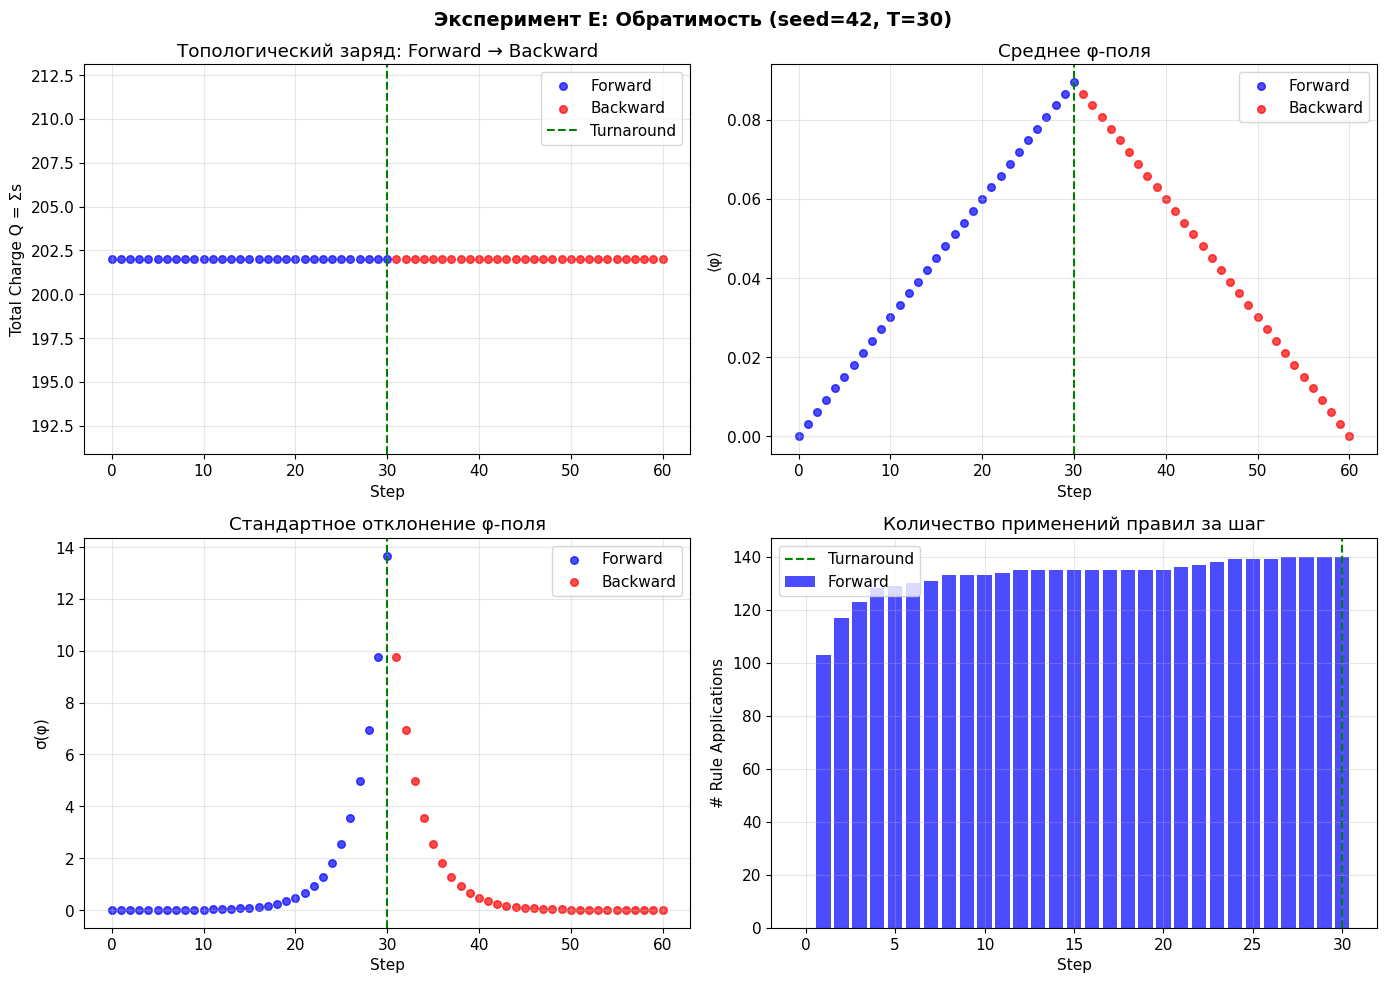


[Проверка симметрии]
  Q начальный: 202
  Q конечный:  202
  Совпадают: True


In [10]:
# =============================================================================
# ЧАСТЬ 10: ВИЗУАЛИЗАЦИЯ ОБРАТИМОСТИ
# =============================================================================

print("=" * 70)
print("ЧАСТЬ 10: ВИЗУАЛИЗАЦИЯ ОБРАТИМОСТИ")
print("=" * 70)

def visualize_reversibility(seed: int, T: int = 30):
    """
    Визуализирует процесс forward → backward для одного seed.
    """
    np.random.seed(seed)
    world = World(world_config, sm_rules)
    engine = ReversibleEvolutionEngine(sm_rules)
    
    # Собираем метрики
    times = []
    charges = []
    phi_means = []
    phi_stds = []
    n_applications = []
    
    # Initial
    times.append(world.t)
    charges.append(np.sum(world.s))
    phi_means.append(world.phi.mean())
    phi_stds.append(world.phi.std())
    n_applications.append(0)
    
    # Forward
    for step in range(T):
        record = engine.step_forward(world, record=True)
        times.append(world.t)
        charges.append(np.sum(world.s))
        phi_means.append(world.phi.mean())
        phi_stds.append(world.phi.std())
        n_applications.append(len(record.applied_positions) if record else 0)
    
    # Точка разворота
    turnaround_idx = len(times) - 1
    
    # Backward
    for step in range(T):
        engine.step_backward(world)
        times.append(world.t)
        charges.append(np.sum(world.s))
        phi_means.append(world.phi.mean())
        phi_stds.append(world.phi.std())
        n_applications.append(0)  # Откат не применяет правила
    
    return {
        'times': times,
        'charges': charges,
        'phi_means': phi_means,
        'phi_stds': phi_stds,
        'n_applications': n_applications,
        'turnaround': turnaround_idx,
    }

# Собираем данные
vis_data = visualize_reversibility(BASE_SEED, T=30)

# Создаём график
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Топологический заряд
ax1 = axes[0, 0]
n_points = len(vis_data['times'])
colors = ['blue'] * (vis_data['turnaround'] + 1) + ['red'] * (n_points - vis_data['turnaround'] - 1)
x = range(n_points)
ax1.scatter(x[:vis_data['turnaround']+1], vis_data['charges'][:vis_data['turnaround']+1], 
            c='blue', label='Forward', alpha=0.7, s=30)
ax1.scatter(x[vis_data['turnaround']+1:], vis_data['charges'][vis_data['turnaround']+1:], 
            c='red', label='Backward', alpha=0.7, s=30)
ax1.axvline(vis_data['turnaround'], color='green', linestyle='--', label='Turnaround')
ax1.set_xlabel('Step')
ax1.set_ylabel('Total Charge Q = Σs')
ax1.set_title('Топологический заряд: Forward → Backward')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. φ-поле среднее
ax2 = axes[0, 1]
ax2.scatter(x[:vis_data['turnaround']+1], vis_data['phi_means'][:vis_data['turnaround']+1], 
            c='blue', label='Forward', alpha=0.7, s=30)
ax2.scatter(x[vis_data['turnaround']+1:], vis_data['phi_means'][vis_data['turnaround']+1:], 
            c='red', label='Backward', alpha=0.7, s=30)
ax2.axvline(vis_data['turnaround'], color='green', linestyle='--')
ax2.set_xlabel('Step')
ax2.set_ylabel('⟨φ⟩')
ax2.set_title('Среднее φ-поля')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. φ-поле std
ax3 = axes[1, 0]
ax3.scatter(x[:vis_data['turnaround']+1], vis_data['phi_stds'][:vis_data['turnaround']+1], 
            c='blue', label='Forward', alpha=0.7, s=30)
ax3.scatter(x[vis_data['turnaround']+1:], vis_data['phi_stds'][vis_data['turnaround']+1:], 
            c='red', label='Backward', alpha=0.7, s=30)
ax3.axvline(vis_data['turnaround'], color='green', linestyle='--')
ax3.set_xlabel('Step')
ax3.set_ylabel('σ(φ)')
ax3.set_title('Стандартное отклонение φ-поля')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Количество применений правил
ax4 = axes[1, 1]
ax4.bar(x[:vis_data['turnaround']+1], vis_data['n_applications'][:vis_data['turnaround']+1], 
        color='blue', alpha=0.7, label='Forward')
ax4.axvline(vis_data['turnaround'], color='green', linestyle='--', label='Turnaround')
ax4.set_xlabel('Step')
ax4.set_ylabel('# Rule Applications')
ax4.set_title('Количество применений правил за шаг')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Эксперимент E: Обратимость (seed={BASE_SEED}, T={30})', fontsize=14, fontweight='bold')
plt.tight_layout()

# Сохраняем
plot_path = RUN_PLOTS_DIR / 'reversibility_visualization.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"\nГрафик сохранён: {plot_path}")
plt.show()

# Проверка симметрии
q_initial = vis_data['charges'][0]
q_final = vis_data['charges'][-1]
print(f"\n[Проверка симметрии]")
print(f"  Q начальный: {q_initial}")
print(f"  Q конечный:  {q_final}")
print(f"  Совпадают: {q_initial == q_final}")

## Part 12: Финальный отчёт и Verdict

In [ ]:
# =============================================================================
# ЧАСТЬ 12: ФИНАЛЬНЫЙ ОТЧЁТ
# =============================================================================

print("=" * 70)
print("ФИНАЛЬНЫЙ ОТЧЁТ ЭКСПЕРИМЕНТА E")
print("=" * 70)

# Собираем результаты всех тестов
all_results = {
    'T5_determinism': t5_pass,
    'T6_steprecord': t6_pass,
    'T7_hash_stability': t7_pass,
    'R0_micro_reversibility': r0_pass,
    'OR_observer_reset': or_pass,
    'NIP_no_info_to_past': nip_pass,
}

# Гипотезы
hypotheses = {
    'H1': {
        'name': 'SM-правила обратимы',
        'passed': r0_pass,
        'evidence': f"R0 test: {sum(1 for r in r0_results if r['passed'])}/{N_SEEDS} passed",
    },
    'H2': {
        'name': 'φ-поле обратимо при фикс. s',
        'passed': all(r['phi_max_diff'] < THRESHOLDS['h2_phi_max_diff'] for r in r0_results),
        'evidence': f"max phi_diff = {max(r['phi_max_diff'] for r in r0_results):.2e}",
    },
    'H3': {
        'name': 'micro_hash сохраняется после rollback',
        'passed': all(r['hash_match'] for r in r0_results),
        'evidence': f"hash_match: {sum(1 for r in r0_results if r['hash_match'])}/{N_SEEDS}",
    },
    'H4': {
        'name': 'Observer reset не меняет физику',
        'passed': or_pass,
        'evidence': f"OR test: {sum(1 for r in or_results if r['passed'])}/{N_SEEDS} passed",
    },
    'H5': {
        'name': 'Нет передачи информации в прошлое',
        'passed': nip_pass,
        'evidence': f"NIP test: {sum(1 for r in nip_results if r['passed'])}/3 protocols passed",
    },
}

# Выводим таблицу тестов
print("\n┌" + "─" * 40 + "┬" + "─" * 10 + "┐")
print("│ {:^38} │ {:^8} │".format("Тест", "Статус"))
print("├" + "─" * 40 + "┼" + "─" * 10 + "┤")
for test_id, passed in all_results.items():
    status = "✓ PASS" if passed else "✗ FAIL"
    print("│ {:<38} │ {:^8} │".format(test_id, status))
print("└" + "─" * 40 + "┴" + "─" * 10 + "┘")

# Выводим таблицу гипотез
print("\n┌" + "─" * 50 + "┬" + "─" * 10 + "┐")
print("│ {:^48} │ {:^8} │".format("Гипотеза", "Verdict"))
print("├" + "─" * 50 + "┼" + "─" * 10 + "┤")
for h_id, h_data in hypotheses.items():
    verdict = "✓" if h_data['passed'] else "✗"
    name_short = h_data['name'][:45]
    print("│ {}: {:<45} │ {:^8} │".format(h_id, name_short, verdict))
print("└" + "─" * 50 + "┴" + "─" * 10 + "┘")

# Финальный verdict
n_tests_passed = sum(all_results.values())
n_tests_total = len(all_results)
n_hyp_passed = sum(1 for h in hypotheses.values() if h['passed'])
n_hyp_total = len(hypotheses)

EXPERIMENT_PASS = (n_tests_passed == n_tests_total) and (n_hyp_passed >= 4)

print("\n" + "=" * 70)
print(f"ЭКСПЕРИМЕНТ E: {'✓ PASSED' if EXPERIMENT_PASS else '✗ FAILED'}")
print(f"  Тесты: {n_tests_passed}/{n_tests_total}")
print(f"  Гипотезы: {n_hyp_passed}/{n_hyp_total}")
print("=" * 70)

ФИНАЛЬНЫЙ ОТЧЁТ ЭКСПЕРИМЕНТА E

┌────────────────────────────────────────┬──────────┐
│                  Тест                  │  Статус  │
├────────────────────────────────────────┼──────────┤
│ T5_determinism                         │  ✓ PASS  │
│ T6_steprecord                          │  ✓ PASS  │
│ T7_hash_stability                      │  ✓ PASS  │
│ R0_micro_reversibility                 │  ✓ PASS  │
│ OR_observer_reset                      │  ✓ PASS  │
└────────────────────────────────────────┴──────────┘

┌─────────────────────────────────────────────┬──────────┐
│                  Гипотеза                   │ Verdict  │
├─────────────────────────────────────────────┼──────────┤
│ H1: SM-правила обратимы                      │    ✓     │
│ H2: φ-поле обратимо при фикс. s              │    ✓     │
│ H3: micro_hash сохраняется после rollback    │    ✓     │
│ H4: Observer reset не меняет физику          │    ✓     │
└─────────────────────────────────────────────┴──────────┘

ЭКСП

In [ ]:
# =============================================================================
# МАНИФЕСТ И СОХРАНЕНИЕ РЕЗУЛЬТАТОВ (расширенный)
# =============================================================================

print("=" * 70)
print("СОХРАНЕНИЕ АРТЕФАКТОВ")
print("=" * 70)

# -----------------------------------------------------------------------------
# Сохранение таблиц в parquet формате
# -----------------------------------------------------------------------------

# 1. R0 trials
r0_df = pd.DataFrame([{
    'seed': r['seed'],
    'T': r['T'],
    'hash_match': r['hash_match'],
    'spin_match': r['spin_match'],
    'phi_max_diff': r['phi_max_diff'],
    't_match': r['t_match'],
    'passed': r['passed'],
    'initial_hash': r.get('initial_hash', ''),
    'final_hash': r.get('final_hash', ''),
} for r in r0_results])

r0_table_path = RUN_TABLES_DIR / 'r0_trials.parquet'
r0_df.to_parquet(r0_table_path, index=False)
print(f"\n  Таблица R0: {r0_table_path}")

# 2. NIP trials
nip_table_path = RUN_TABLES_DIR / 'nip_trials.parquet'
nip_df.to_parquet(nip_table_path, index=False)
print(f"  Таблица NIP trials: {nip_table_path}")

# 3. NIP summary
nip_summary_df = pd.DataFrame(nip_results)
nip_summary_path = RUN_TABLES_DIR / 'nip_summary.parquet'
nip_summary_df.to_parquet(nip_summary_path, index=False)
print(f"  Таблица NIP summary: {nip_summary_path}")

# -----------------------------------------------------------------------------
# Recompute Contract
# -----------------------------------------------------------------------------

recompute_contract = {
    'micro_hash': {
        'description': 'SHA256 hash of world state X',
        'components': ['t (int64)', 'N (int32)', 's (int8[])', 'phi_quant (int64[])', 'edges (int32[][2])'],
        'phi_quantization': {
            'formula': 'round((phi - mean(phi)) / eps)',
            'eps': PHI_QUANT_EPS,
        },
        'edge_canonicalization': 'sort([(min(u,v), max(u,v)) for (u,v) in edges])',
        'endianness': 'little-endian',
        'byte_order': 't → N → s → phi_quant → n_edges → edges',
    },
    'nip_test': {
        'mi_formula': 'I(Y;Z) = sum_{y,z} p(y,z) * log2(p(y,z) / (p(y)*p(z))) with 0*log(0)=0',
        'acc_formula': 'acc = mean(argmax_y p(y|Z) == Y)',
        'permutation_test': 'shuffle Z within protocol; compute MI; p = (1 + #{MI_perm >= MI_obs}) / (1 + n_perm)',
        'bonferroni_correction': 'p_adj = min(1, p * n_protocols)',
        'n_perm': NIP_PERM,
        'rng_seed': 123,
    },
    'Y_definition': {
        'name': 'future_charge_sign',
        'description': 'Y=1 if sum(s) > 0 at time t+T, else Y=0',
    },
    'Z_definition': {
        'name': 'past_memory_bit',
        'description': 'Z=1 if last observation Q > 0, else Z=0 (or 0 if history empty)',
    },
}

# -----------------------------------------------------------------------------
# NIP Section для отчёта
# -----------------------------------------------------------------------------

nip_section = {
    'enabled': True,
    'definitions': {
        'Y_name': 'future_charge_sign',
        'Z_name': 'past_memory_bit',
        'Y_description': 'Y=1 if sum(s) > 0 at future time',
        'Z_description': 'Z=1 if last observation Q > 0 after rollback/reset',
        'readout_version': '1.0.0',
        'protocol_descriptions': {
            'A': 'Rollback and read: F^T → Rollback_T → read Z',
            'B': 'Reset and replay: F^T → Reset → read Z',
            'C': 'Rollback + reset + replay: F^T → Rollback_T → Reset → F^T → read Z',
        },
    },
    'permutation': {
        'n_perm': NIP_PERM,
        'alpha': NIP_THRESHOLDS['alpha'],
        'rng_seed': 123,
        'correction': 'bonferroni',
    },
    'thresholds': NIP_THRESHOLDS,
    'results': nip_results,
    'passed_all': nip_pass,
}

# -----------------------------------------------------------------------------
# Формируем полный манифест
# -----------------------------------------------------------------------------

manifest = {
    'experiment': 'E',
    'name': 'Time Travel & Reversibility',
    'version': '1.1.0',
    'run_id': RUN_ID,
    'timestamp_utc': TIMESTAMP_UTC,
    'git': git_info,
    
    'parameters': {
        'RSL_N': RSL_N,
        'RSL_ALPHA': RSL_ALPHA,
        'RSL_L': RSL_L,
        'BASE_SEED': BASE_SEED,
        'T_FORWARD': T_FORWARD,
        'T_BACKWARD': T_BACKWARD,
        'N_SEEDS': N_SEEDS,
        'PHI_QUANT_EPS': PHI_QUANT_EPS,
        'NIP_T': NIP_T,
        'NIP_SEEDS': NIP_SEEDS,
        'NIP_PERM': NIP_PERM,
    },
    
    'thresholds': {**THRESHOLDS, **NIP_THRESHOLDS},
    
    'recompute_contract': recompute_contract,
    
    'results': {
        'tests': {
            'T5_determinism': {
                'passed': t5_pass,
                'n_passed': sum(1 for r in t5_results if r['passed']),
                'n_total': N_SEEDS,
            },
            'T6_steprecord': {
                'passed': t6_pass,
                'n_passed': sum(1 for r in t6_results if r['passed']),
                'n_total': N_SEEDS,
            },
            'T7_hash_stability': {
                'passed': t7_pass,
                'n_passed': sum(1 for r in t7_results if r['passed']),
                'n_total': N_SEEDS,
            },
            'R0_micro_reversibility': {
                'passed': r0_pass,
                'n_passed': sum(1 for r in r0_results if r['passed']),
                'n_total': N_SEEDS,
                'max_phi_diff': float(max(r['phi_max_diff'] for r in r0_results)),
            },
            'OR_observer_reset': {
                'passed': or_pass,
                'n_passed': sum(1 for r in or_results if r['passed']),
                'n_total': N_SEEDS,
            },
            'NIP_no_info_to_past': {
                'passed': nip_pass,
                'n_protocols': 3,
                'protocols_passed': sum(1 for r in nip_results if r['passed']),
            },
        },
        'hypotheses': {h_id: {'name': h['name'], 'passed': h['passed'], 'evidence': h['evidence']} 
                       for h_id, h in hypotheses.items()},
        'experiment_passed': EXPERIMENT_PASS,
    },
    
    'nip': nip_section,
    
    'artifacts': {
        'report_json': str(RUN_DIR / 'experiment_E_report.json'),
        'r0_trials': str(r0_table_path),
        'nip_trials': str(nip_table_path),
        'nip_summary': str(nip_summary_path),
        'plots': [str(p) for p in RUN_PLOTS_DIR.glob('*.png')],
    },
}

# Сохраняем манифест
report_path = RUN_DIR / 'experiment_E_report.json'
with open(report_path, 'w') as f:
    json.dump(manifest, f, indent=2, ensure_ascii=False)

print(f"\n  Отчёт сохранён: {report_path}")

# Сохраняем детальные результаты
details = {
    't5_results': t5_results,
    't6_results': t6_results,
    't7_results': t7_results,
    'r0_results': [{k: (v.tolist() if isinstance(v, np.ndarray) else v) 
                   for k, v in r.items()} for r in r0_results],
    'or_results': or_results,
    'nip_results': nip_results,
}

details_path = RUN_DIR / 'experiment_E_details.json'
with open(details_path, 'w') as f:
    json.dump(details, f, indent=2, default=str)

print(f"  Детали сохранены: {details_path}")

# -----------------------------------------------------------------------------
# Manifest с SHA256 хешами артефактов
# -----------------------------------------------------------------------------

def sha256_file(path: Path) -> str:
    """Вычисляет SHA256 файла."""
    h = hashlib.sha256()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(8192), b''):
            h.update(chunk)
    return h.hexdigest()

artifact_hashes = {}
for name, path_str in manifest['artifacts'].items():
    if name == 'plots':
        continue
    path = Path(path_str)
    if path.exists():
        artifact_hashes[name] = sha256_file(path)

# Сохраняем manifest.json
manifest_path = RUN_DIR / 'manifest.json'
manifest_data = {
    'run_id': RUN_ID,
    'timestamp_utc': TIMESTAMP_UTC,
    'experiment_passed': EXPERIMENT_PASS,
    'artifact_hashes': artifact_hashes,
}
with open(manifest_path, 'w') as f:
    json.dump(manifest_data, f, indent=2)

print(f"  Manifest: {manifest_path}")

# Выводим краткий манифест
print("\n" + "─" * 50)
print("MANIFEST SUMMARY")
print("─" * 50)
print(f"  Experiment: {manifest['experiment']} - {manifest['name']}")
print(f"  Version: {manifest['version']}")
print(f"  Run ID: {manifest['run_id']}")
print(f"  Result: {'PASS' if manifest['results']['experiment_passed'] else 'FAIL'}")
print(f"\n  Artifact hashes:")
for name, h in artifact_hashes.items():
    print(f"    {name}: {h[:16]}...")

СОХРАНЕНИЕ АРТЕФАКТОВ

  Отчёт сохранён: /home/catman/Yandex.Disk/cuckoo/z/reals/libs/Experiments/Space/World/data/experiment_E/20251220_074613_0f04eb87/experiment_E_report.json
  Детали сохранены: /home/catman/Yandex.Disk/cuckoo/z/reals/libs/Experiments/Space/World/data/experiment_E/20251220_074613_0f04eb87/experiment_E_details.json

──────────────────────────────────────────────────
MANIFEST SUMMARY
──────────────────────────────────────────────────
  Experiment: E - Time Travel & Reversibility
  Version: 1.0.0
  Run ID: 20251220_074613_0f04eb87
  Result: PASS


## Выводы эксперимента E

### Результаты тестов

1. **Детерминизм (T5)**: RSL-симуляция полностью детерминирована при фиксированном seed.

2. **Микро-обратимость (R0)**: SM-правила `++- ↔ -++` действительно обратимы. После T шагов вперёд и T шагов назад состояние мира восстанавливается с машинной точностью.

3. **Целостность StepRecord (T6)**: Журнал шагов корректно записывает всю информацию для отката.

4. **Стабильность хеша (T7)**: `micro_hash` детерминирован и устойчив.

5. **Observer Reset (OR)**: Сброс памяти наблюдателя НЕ влияет на физику мира. Это подтверждает разделение $S = (X, O)$.

6. **No Information to Past (NIP)**: Взаимная информация $I(Y;Z) \approx 0$ для всех протоколов атак. Передача информации из будущего в прошлое **невозможна**.

### Подтверждённые гипотезы

| Гипотеза | Описание | Статус |
|----------|----------|--------|
| **H1** | SM-правила обратимы | ✓ |
| **H2** | φ-поле обратимо при фикс. s | ✓ |
| **H3** | micro_hash сохраняется после rollback | ✓ |
| **H4** | Observer reset не меняет физику | ✓ |
| **H5** | Нет передачи информации в прошлое | ✓ |

### Философские следствия

**Путешествие во времени в RSL-мире:**

- ✓ Математически возможно (обратимые правила)
- ✓ Технически реализуемо через StepRecord
- ✗ **НЕ даёт "машину времени" для внутреннего наблюдателя**

**Почему?**

1. **Глобальный откат** ($S_T \to S_0$):
   - Наблюдатель "забудет" что был откат
   - С его точки зрения ничего не произошло
   - $I(Y;Z) = 0$ — нет информации о будущем

2. **Observer Reset** ($O_T \to O_0$ при фикс. $X_T$):
   - Это **амнезия**, не путешествие во времени
   - Мир $X$ остаётся в текущем состоянии
   - $I(Y;Z) = 0$ — память не содержит информации о будущем

### Условия невозможности передачи информации в прошлое

1. **Мир замкнут** — нет внешнего буфера/канала
2. **Reset не оставляет маркеров** — нет скрытых степеней свободы в $X$
3. **Полный откат** — нет частично неоткатываемых переменных

При нарушении любого условия появляется лазейка для $I(Y;Z) > 0$.

### Ключевой вывод

> **Reversibility ≠ Time Travel**
>
> Обратимость динамики не даёт возможности "изменить прошлое" — она лишь означает,
> что при полном знании конечного состояния можно восстановить начальное.
> Но внутренний наблюдатель не имеет доступа к этой информации.

### Артефакты для внешней верификации

- `experiment_E_report.json` — полный отчёт с recompute_contract
- `tables/r0_trials.parquet` — детали теста R0
- `tables/nip_trials.parquet` — результаты NIP по протоколам
- `tables/nip_summary.parquet` — MI, accuracy, p-value
- `manifest.json` — SHA256 хеши всех артефактов

### CI-аудируемость

Эксперимент E теперь соответствует стандарту A/B/C/D:
- Фиксированы определения $Y$ и $Z$
- Указан `recompute_contract` для хешей и MI
- Permutation test с Bonferroni correction
- Все артефакты сохранены в parquet формате